In [2]:
import pandas as pd
import numpy as np
import operator
import torch
import os
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as AF
from torch.utils.data import random_split, Subset
from torch.distributions.normal import Normal
import random



# adding gaussian noise to an image
def addNoise(input, std_dev = 0.5, mean=0.0):
    # Create Normal distribution object with mean=0 and std_dev as the standard deviation
    dist = Normal(torch.tensor([mean]), torch.tensor([std_dev]))
    # Generate random Gaussian noise with same size as the input image
    noise = dist.sample(input.size()).squeeze()
    # Add noise to the image
    noisy_input = input + noise
    # Clip pixel values to be between 0 and 1
    noisy_input = torch.clamp(noisy_input, 0.0, 1.0)
    return noisy_input
    
# custom dataset class for our image data
class GRSSDataset(Dataset):
    def __init__(self, root_path, RGB_SAR_transform, DSM_transform):
        self.dsm_path=os.path.join(root_path,"dsm")
        self.rgb_path=os.path.join(root_path,"rgb")
        self.sar_path=os.path.join(root_path,"sar")
        self.dsm_list=os.listdir(self.dsm_path)
        self.rgb_list=os.listdir(self.rgb_path)
        self.sar_list=os.listdir(self.sar_path)
        self.dsm_list.sort()
        self.rgb_list.sort()
        self.sar_list.sort()
        self.length=len(self.dsm_list)
        self.RGB_SAR_transform=RGB_SAR_transform
        self.DSM_transform=DSM_transform
        self.transform=transforms.Compose([transforms.ToTensor()])
        
    def __len__(self):
        return self.length
    
    def __getitem__(self,index):
        dsm=Image.open(os.path.join(self.dsm_path,self.dsm_list[index]))
        rgb=Image.open(os.path.join(self.rgb_path,self.rgb_list[index]))
        sar=Image.open(os.path.join(self.sar_path,self.sar_list[index]))
        dsm=self.DSM_transform(dsm)
#         dsm=dsm/183.1741180419922
        rgb=self.transform(rgb)
        sar=self.transform(sar)
        sar=sar/503.60028076171875
        stacked=torch.cat((rgb,sar),dim=0)
        stacked=self.RGB_SAR_transform(stacked)
#         #adding random noise
#         rand=random.random()
#         stacked=addNoise(std_dev=rand, input=stacked)
        return (stacked,dsm)

#cuda access
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#batch size
batch_size=4

#custom transform
RGB_SAR_transform = transforms.Compose([
#     transforms.Normalize(mean=[0.3176, 0.3440, 0.2821, 0.2634], std=[0.1609, 0.1448, 0.1460, 0.3725])
]) 
DSM_transform = transforms.Compose([
    transforms.ToTensor(),
#     transforms.Normalize(mean=[4.9655], std=[7.5816])
]) 
transform=transforms.Compose([transforms.ToTensor()])
#dataset class initialization
dataset=GRSSDataset(root_path="/kaggle/input/2023-ieee-grss-data-fusion-contest/track2/train", 
                    RGB_SAR_transform=RGB_SAR_transform,
                    DSM_transform=DSM_transform
                   )

#split
train_data, test_data = random_split(dataset, [1600, 173])
# train_data = Subset(dataset, [i for i in range(1600)])
# test_data = Subset(dataset, [i for i in range(1600,1773,1)])

# # Dataloader for training dataset
train_loader=DataLoader(dataset=train_data, batch_size=batch_size,shuffle=True)
# # Dataloader for testing dataset
test_loader=DataLoader(dataset=test_data, batch_size=batch_size,shuffle=True)


In [3]:
!pip install sigpy

In [4]:
import torch
import torch.nn as nn
from torch.autograd import Function
import math
import operator
import cupy as cp
import sigpy as sp


def _spectral_crop(array, array_shape, bounding_shape):
    start = tuple(map(lambda a, da: (a-da)//2, array_shape, bounding_shape))
    end = tuple(map(operator.add, start, bounding_shape))
    slices = tuple(map(slice, start, end))
    return array[slices]

def _spectral_pad(array, array_shape, bounding_shape):
    out = cp.zeros(bounding_shape)
    start = tuple(map(lambda a, da: (a-da)//2, bounding_shape, array_shape))
    end = tuple(map(operator.add, start, array_shape))
    slices = tuple(map(slice, start, end))
    out[slices] = array
    return out

def DiscreteHartleyTransform(input):
    N = input.ndim
    axes_n = np.arange(2,N)
    fft = sp.fft(input, axes=axes_n)
    H = fft.real - fft.imag
    return H

def CropForward(input, return_shape):

    output_shape = np.zeros(input.ndim).astype(int)
    output_shape[0] = input.shape[0]
    output_shape[1] = input.shape[1]
    output_shape[2:] = np.asarray(return_shape).astype(int)

    dht = DiscreteHartleyTransform(input)
    dht = _spectral_crop(dht, dht.shape, output_shape)
    dht = DiscreteHartleyTransform(dht)

    return dht

def PadBackward(grad_output, input_shape):
    dht = DiscreteHartleyTransform(grad_output)
    dht = _spectral_pad(dht, dht.shape, input_shape)
    dht = DiscreteHartleyTransform(dht)

    return dht


class SpectralPoolingFunction(Function):
    @staticmethod
    def forward(ctx, input, return_shape):
         input = sp.from_pytorch(input)
         ctx.input_shape = input.shape
         output = CropForward(input, return_shape)
         output = sp.to_pytorch(output)
         output = output.float()
         return output

    @staticmethod
    def backward(ctx, grad_output):
        grad_output = sp.from_pytorch(grad_output)
        grad_input = PadBackward(grad_output, ctx.input_shape)
        grad_input = sp.to_pytorch(grad_input)
        grad_input = grad_input.float()
        return grad_input, None, None


# class SpectralPoolNd(nn.Module):
#     def __init__(self, return_shape):
#         super(SpectralPoolNd, self).__init__()
#         self.return_shape = return_shape

#     def forward(self, input):
#         return SpectralPoolingFunction.apply(input, self.return_shape)
class SpectralPoolNd(nn.Module):
    def __init__(self):
        super(SpectralPoolNd, self).__init__()
#         self.return_shape = return_shape

    def forward(self, input, return_shape):
        return SpectralPoolingFunction.apply(input, return_shape)

In [33]:
import torch.nn as nn
import torchvision.transforms.functional as TF


class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(DoubleConv,self).__init__()
    self.conv=nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3,1,1,bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3,1,1,bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )
  
  def forward(self,x):
    return self.conv(x)



class UNET(nn.Module):
  def __init__(self, in_channels=4, out_channels=1,features=[16,32,64,128]):
    super(UNET, self).__init__()
    self.downs=nn.ModuleList()
    self.ups=nn.ModuleList()
#     self.pool=nn.MaxPool2d(kernel_size=2, stride=2)
#     self.pool=nn.AvgPool2d(kernel_size=2, stride=2)
    self.pool=SpectralPoolNd()
    self.sigmoid=nn.Sigmoid()
    self.relu=nn.ReLU()

    #Down part of UNET
    for feature in features:
      self.downs.append(DoubleConv(in_channels, feature))
      in_channels=feature

    #up part of UNET
    for feature in reversed(features):
#       self.ups.append(nn.ConvTranspose2d(feature*2, feature,kernel_size=2, stride=2))
      self.ups.append(NearestNeighborBlock(feature*2, feature))
      self.ups.append(DoubleConv(feature*2, feature))

    self.bottleneck=DoubleConv(features[-1],features[-1]*2)
    self.final_conv=nn.Conv2d(features[0],out_channels,kernel_size=1)


  def forward(self, x):
    skip_connections=[]

    for down in self.downs:
      x=down(x)
      skip_connections.append(x)
#       x=self.pool(x)
      shape=[]
      shape.append(x.shape[-2]//2)
      shape.append(x.shape[-1]//2)
#       print(shape)
      x=self.pool(x,return_shape=shape)

    x=self.bottleneck(x)
    skip_connections=skip_connections[::-1]
    for idx in range(0, len(self.ups),2):
      x=self.ups[idx](x)
      skip_connect=skip_connections[idx//2]
      concat_skip=torch.cat((skip_connect,x), dim=1)
      x=self.ups[idx+1](concat_skip)
    
    return self.relu(self.final_conv(x))


class DiceLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, y_pred, y_true, smooth=1):
        y_pred = y_pred.flatten()
        y_true = y_true.flatten()
        y_pred=torch.where(y_pred == 0, torch.zeros_like(y_pred), torch.ones_like(y_pred))
        y_true=torch.where(y_true == 0, torch.zeros_like(y_true), torch.ones_like(y_true))
        intersection = torch.sum(y_pred * y_true)
        coefficient = (2.0 * intersection + smooth) / (torch.sum(y_pred) + torch.sum(y_true) + smooth)
        return coefficient
#         # Flatten both inputs
#         input = input.view(-1)
#         target = target.view(-1)

#         # Compute intersection and union
#         intersection = (input * target).sum()
#         union = input.sum() + target.sum()

#         # Compute Dice score
#         dice = (2 * intersection + smooth) / (union + smooth)

#         # Compute Dice loss
# #         loss = 1 - dice
#         loss = dice

#         return loss
    
#     # Dice Score
# def dice_coefficient(y_pred, y_true):
#     smooth = 0.000001  # smoothing parameter to prevent division by zero
#     y_pred = y_pred.flatten()
#     y_true = y_true.flatten()
#     y_pred=torch.where(y_pred == 0, torch.zeros_like(y_pred), torch.ones_like(y_pred))
#     y_true=torch.where(y_true == 0, torch.zeros_like(y_true), torch.ones_like(y_true))
#     intersection = torch.sum(y_pred * y_true)
#     coefficient = (2.0 * intersection + smooth) / (torch.sum(y_pred) + torch.sum(y_true) + smooth)
#     return coefficient

# class DiceBCELoss(torch.nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.bce = torch.nn.BCEWithLogitsLoss()
#         self.dice = DiceLoss()

#     def forward(self, input, target, smooth=1):
#         bce_loss = self.bce(input, target)
#         dice_loss = self.dice(torch.sigmoid(input), target, smooth=smooth)
#         loss = bce_loss + dice_loss

#         return loss
    
class DiceMSELoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = torch.nn.MSELoss()
        self.dice = DiceLoss()

    def forward(self, input, target, smooth=1):
        mse_loss = self.mse(input, target)
        dice_loss = self.dice(input, target, smooth=smooth)
#         loss = mse_loss*dice_loss
        loss = mse_loss/dice_loss
        return loss



In [34]:

import torch.nn as nn
import torchvision.transforms.functional as TF

class InceptionBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(InceptionBlock, self).__init__()
        self.conv1x1 = nn.Conv2d(in_channels, out_channels//4, kernel_size=1)
        self.conv3x3_1 = nn.Conv2d(in_channels, out_channels//4, kernel_size=1)
        self.conv3x3_2 = nn.Conv2d(out_channels//4, out_channels//4, kernel_size=3, padding=1)
        self.conv5x5_1 = nn.Conv2d(in_channels, out_channels//4, kernel_size=1)
        self.conv5x5_2 = nn.Conv2d(out_channels//4, out_channels//4, kernel_size=5, padding=2)
        self.conv_pool = nn.Conv2d(in_channels, out_channels//4, kernel_size=1)
        self.pool=nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
#         self.conv7x7_1 = nn.Conv2d(in_channels, out_channels//4, kernel_size=1)
#         self.conv7x7_2 = nn.Conv2d(out_channels//4, out_channels//4, kernel_size=7, padding=3)
#         self.pool=nn.AvgPool2d(kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        conv1x1 = self.conv1x1(x)
#         print(conv1x1.shape)
        conv3x3 = self.conv3x3_1(x)
        conv3x3 = self.conv3x3_2(conv3x3)
#         print(conv3x3.shape)
        conv5x5 = self.conv5x5_1(x)
        conv5x5 = self.conv5x5_2(conv5x5)
#         print(conv5x5.shape)
        pool = self.pool(x)
        pool = self.conv_pool(pool)
        output = torch.cat([conv1x1, conv3x3, conv5x5, pool], dim=1)
#         conv7x7 = self.conv7x7_1(x)
#         conv7x7 = self.conv7x7_2(conv7x7)
#         output = torch.cat([conv1x1, conv3x3, conv5x5, conv7x7], dim=1)
        return output

class TransposedBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransposedBlock, self).__init__()
        self.channels=in_channels//4
        self.conv= nn.ConvTranspose2d(in_channels//4, out_channels//4, kernel_size=2, stride=2)
#         self.conv3x3 = nn.ConvTranspose2d(in_channels//4, out_channels//4, kernel_size=2, stride=2)
#         self.conv5x5 = nn.ConvTranspose2d(in_channels//4, out_channels//4, kernel_size=2, stride=2)
#         self.maxPool = nn.ConvTranspose2d(in_channels//4, out_channels//4, kernel_size=2, stride=2)

    def forward(self, x):
        conv1x1 = self.conv(x[:, 0:self.channels, :, :])
        conv3x3 = self.conv(x[:, self.channels:2*self.channels, :, :])
        conv5x5 = self.conv(x[:, 2*self.channels:3*self.channels, :, :])
        pool = self.conv(x[:, 3*self.channels:, :, :])
        output = torch.cat([conv1x1, conv3x3, conv5x5, pool], dim=1)
        return output
    
class NearestNeighborBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.upsample=nn.Upsample(scale_factor=2, mode='bicubic')
        
    def forward(self, x):
        x = self.upsample(x)
        x = self.conv(x)
        return x


class InceptionUNET(nn.Module):
  def __init__(self, in_channels=4, out_channels=1,features=[16,32,64,128]):
    super(InceptionUNET, self).__init__()
    self.downs=nn.ModuleList()
    self.ups=nn.ModuleList()
    self.pool=nn.MaxPool2d(kernel_size=2, stride=2)
#     self.pool=nn.AvgPool2d(kernel_size=2, stride=2)
#     self.pool=SpectralPoolNd()
    self.sigmoid=nn.Sigmoid()
    self.relu=nn.ReLU()

    #Down part of UNET
    for feature in features:
        self.downs.append(InceptionBlock(in_channels, feature))
        in_channels=feature

    #up part of UNET
    for feature in reversed(features):
        self.ups.append(TransposedBlock(feature*2, feature))
#         self.ups.append(NearestNeighborBlock(feature*2, feature))
#         self.ups.append(DoubleConv(feature*2, feature))
        self.ups.append(InceptionBlock(feature*2, feature))

    self.bottleneck=DoubleConv(features[-1],features[-1]*2)
    self.final_conv=nn.Conv2d(features[0],out_channels,kernel_size=1)


  def forward(self, x):
    skip_connections=[]

    for down in self.downs:
      x=down(x)
      skip_connections.append(x)
      x=self.pool(x)
#       shape=[]
#       shape.append(x.shape[-2]//2)
#       shape.append(x.shape[-1]//2)
#       print(shape)
#       x=self.pool(x,return_shape=shape)

    x=self.bottleneck(x)
    
    skip_connections=skip_connections[::-1]
    for idx in range(0, len(self.ups),2):
      x=self.ups[idx](x)
      skip_connect=skip_connections[idx//2]
      filters=skip_connect.shape[1]
      conv1x1=torch.cat((skip_connect[:, 0:filters,:,:],x[:, 0:filters,:,:]), dim=1)
      conv3x3=torch.cat((skip_connect[:, filters:2*filters,:,:],x[:, filters:2*filters,:,:]), dim=1)
      conv5x5=torch.cat((skip_connect[:, 2*filters:3*filters,:,:],x[:, 2*filters:3*filters,:,:]), dim=1)
      pooll=torch.cat((skip_connect[:, 3*filters:,:,:],x[:, 3*filters:,:,:]), dim=1)
      concat_skip=torch.cat([conv1x1, conv3x3, conv5x5, pooll], dim=1)
      x=self.ups[idx+1](concat_skip)
    
    return self.relu(self.final_conv(x))

# model=InceptionUNET()
# print(model)

In [35]:
model=UNET()
# model=InceptionUNET()
model=model.to(device)
# lossFunction=nn.MSELoss()
lossFunction=DiceMSELoss()
# lossFunction=nn.L1Loss()
optimizer=torch.optim.Adam(model.parameters(), lr=0.001)

#loading the saved  model
# state_dict = torch.load('/kaggle/working/Post_modell_49')
# state_dict = torch.load('/kaggle/input/ail861-project-models/model_Layers4_50epoch')
# model.load_state_dict(state_dict)

# training
def train(epoch=50):
    l=[]
    for ep in range(epoch):
        for i, (img,target) in enumerate(train_loader):
    #         print(img.size())
            img=img.to(device)
            target=target.to(device)
            out=model(img)
            loss=lossFunction(target.float(),out)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if(i%10==0):
                print(loss.item())
    #             print(out)
        if(ep%10==9):
            torch.save(model.state_dict(), f'Post_modell_{ep}')
        print(f'{ep+1} epoch Finished')
        valAcc=test(test_loader)
        l.append(valAcc)
        print(f'Average test RSM error: {valAcc}')
#         print(f'Average training dice score: {test(train_loader)}')
    return l
        
testLossFunction=DiceMSELoss()

def test(loader, noise=False, std=0.1):
    RMS_sum=0
    with torch.no_grad():
        for i, (img,target) in enumerate(loader):
            if noise:
                img=addNoise(std_dev=std, input=img)
            img=img.to(device)
            target=target.to(device)
            out=model(img)
            loss=testLossFunction(target.float(),out)
            RMS_sum+=loss.item()
#             for j in range(len(out)):
#                 dice_sum+=dice_coefficient(target[j],out[j])
#     return RMS_sum/(len(loader)*batch_size)
    return RMS_sum/len(loader)
        


In [36]:
print(f'Average test RMS loss: {test(test_loader)}')
l=train(51)
print(l)

Average test RMS loss: 285.1420073075728
340.2378234863281
11.935154914855957
86.87155151367188
106.99344635009766
127.96054077148438
27.629138946533203
163.1153106689453
105.43508911132812
243.7957000732422
626.138916015625
299.358154296875
79.3776626586914
67.5654296875
167.68333435058594
40.12033462524414
60.7756233215332
80.42050170898438
114.11087036132812
119.37151336669922
335.6463623046875
60.69449234008789
116.27482604980469
161.4501495361328
40.22547149658203
160.08314514160156
206.0054473876953
300.1766052246094
503.5690002441406
65.53853607177734
435.65228271484375
120.69676208496094
165.51248168945312
74.3843994140625
245.9859161376953
60.349788665771484
49.12720489501953
232.57550048828125
123.58527374267578
150.7728271484375
106.2752685546875
1 epoch Finished
Average test RSM error: 202.21808841011742
93.06651306152344
96.21476745605469
91.33727264404297
74.14442443847656
72.33639526367188
295.57269287109375
542.103515625
215.00657653808594
113.48405456542969
114.4600830

In [8]:
# torch.save(model.state_dict(), 'model_30_epoch')

def addNoise(input, std_dev = 0.5, mean=0.0):
    # Create Normal distribution object with mean=0 and std_dev as the standard deviation
    dist = Normal(torch.tensor([mean]), torch.tensor([std_dev]))
    # Generate random Gaussian noise with same size as the input image
    noise = dist.sample(input.size()).squeeze()
    # Add noise to the image
    noisy_input = input + noise
    # Clip pixel values to be between 0 and 1
    noisy_input = torch.clamp(noisy_input, 0.0, 1.0)
    return noisy_input



tensor([[[ 0.0000,  0.0000,  0.0000,  ..., 32.9572, 32.8753, 32.8243],
         [ 0.0000,  0.0000,  0.0000,  ..., 32.9343, 32.8481, 32.7944],
         [ 0.0000,  0.0000,  0.0000,  ..., 32.8976, 32.8047, 32.7468],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]],
       device='cuda:0')
tensor([[[[ 1.7517,  0.2583,  0.5741,  ..., 22.2150, 21.1962, 16.8811],
          [ 0.3720,  0.1489,  0.3415,  ..., 25.7535, 25.7165, 21.9305],
          [ 1.2717,  0.4625,  3.1570,  ..., 25.0622, 26.9412, 23.7587],
          ...,
          [ 0.1489,  0.1489,  0.1489,  ...,  0.5016,  0.1489,  0.5727],
          [ 0.1489,  0.1489,  0.1489,  ...,  0.1489,  0.6620,  0.6450],
          [ 0.6840,  0.1489,  0.1489,  ...,  0.3091,  0.5671,  1.6128]]]],
       device='cuda:0', grad_fn=<ReluBackward0>)
tensor(0.6299, device='cuda:0')
ten

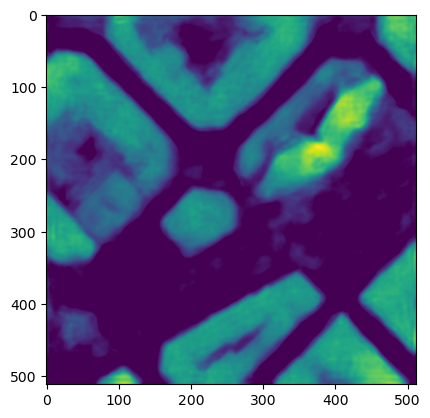

In [37]:
image=(dataset[100])
inp=image[0]
inp=inp.unsqueeze(0)
# inp=addNoise(std_dev=1, input=inp)
inp=inp.to(device)
tar=image[1]
tar=tar.to(device)
out=model(inp)
# out=(out-out.mean())/out.std()
# print(dice_coefficient(model.sigmoid(tar),model.sigmoid(out)))
print(tar)
print(out)
# print(interpolate(tar,0,183.1741180419922))
# print(interpolate(out,0,100022))
# print(out)
# print(dice_coefficient(tar,out))
# print(generalized_dice(tar.unsqueeze(0),out.unsqueeze(0)))
dice=DiceLoss()
MSE=nn.MSELoss()
print(dice(tar,out))
print(MSE(tar,out))
with torch.no_grad():
    loss=lossFunction(tar,out)
    print(loss.item())
out=out.squeeze(1)
out=out.permute(1,2,0)
plt.imshow(out.cpu().detach().numpy())

torch.Size([1, 512, 512])


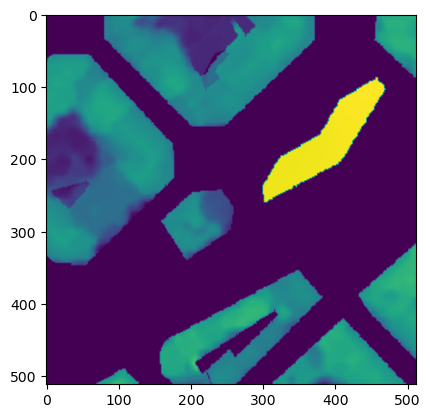

In [71]:
tar=(dataset[100])[1]
print(tar.shape)
tar=tar.permute(1,2,0)
# tar = torch.where(tar == 0, torch.zeros_like(tar), torch.ones_like(tar))
plt.imshow(tar.cpu().detach().numpy())

In [12]:
# custom dataset class for our image data
class GRSSDatasetVal(Dataset):
    def __init__(self, root_path, RGB_SAR_transform):
        self.rgb_path=os.path.join(root_path,"rgb")
        self.sar_path=os.path.join(root_path,"sar")
        self.rgb_list=os.listdir(self.rgb_path)
        self.sar_list=os.listdir(self.sar_path)
        self.rgb_list.sort()
        self.sar_list.sort()
        self.length=len(self.rgb_list)
        self.RGB_SAR_transform=RGB_SAR_transform
        self.transform=transforms.Compose([transforms.ToTensor()])
        
    def __len__(self):
        return self.length
    
    def __getitem__(self,index):
        rgb=Image.open(os.path.join(self.rgb_path,self.rgb_list[index]))
        sar=Image.open(os.path.join(self.sar_path,self.sar_list[index]))
        rgb=self.transform(rgb)
        sar=self.transform(sar)
        stacked=torch.cat((rgb,sar),dim=0)
        stacked=self.RGB_SAR_transform(stacked)
        return (stacked)
    
valdataset=GRSSDatasetVal(root_path='/kaggle/input/2023-ieee-grss-data-fusion-contest/track2/val',RGB_SAR_transform=RGB_SAR_transform)
# testset=GRSSDatasetVal(root_path='/kaggle/input/grss-track2-test-dataset/track2_test_data',RGB_SAR_transform=RGB_SAR_transform)


tensor(0.3136, device='cuda:0')
tensor(3.9397, device='cuda:0', grad_fn=<MseLossBackward0>)
12.56122875213623


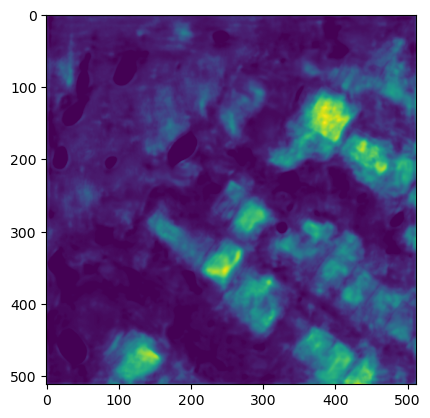

In [39]:
inp=(test_data[14])[0]
tar=(test_data[14])[1]
inp=inp.unsqueeze(0)
# inp=addNoise(std_dev=4, image=inp)
inp=inp.to(device)
tar=tar.to(device)
out=model(inp)
print(dice(tar,out))
print(MSE(tar,out))
with torch.no_grad():
    loss=lossFunction(tar,out)
    print(loss.item())
out=out.squeeze(1)
out=out.permute(1,2,0)
plt.imshow(out.cpu().detach().numpy())

torch.Size([4, 512, 512])


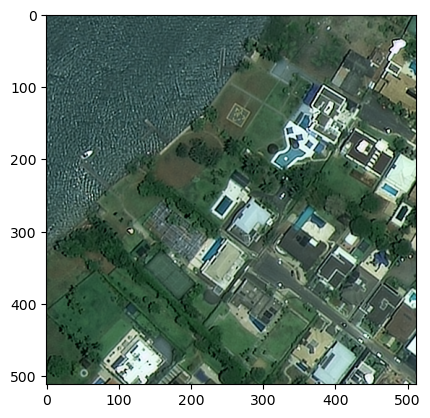

In [16]:
tar=(test_data[14])[0]
print(tar.shape)
tar=tar[0:3,::]
# tar=tar[3:4,::]
# tar=addNoise(std_dev=0.2, image=tar)
tar=tar.permute(1,2,0)
plt.imshow(tar.cpu().detach().numpy())

torch.Size([1, 512, 512])


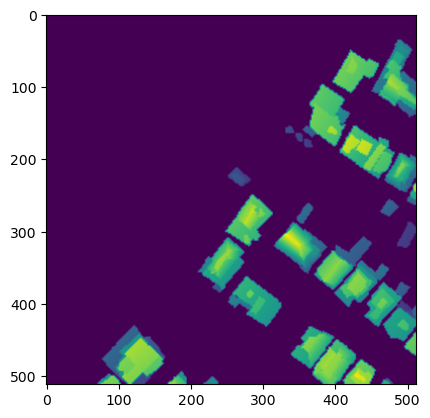

In [40]:
tar=(test_data[14])[1]
print(tar.shape)
# tar=tar[0:3,::]
# tar=tar[3:4,::]
# tar=addNoise(std_dev=0.2, image=tar)
tar=tar.permute(1,2,0)
plt.imshow(tar.cpu().detach().numpy())

In [8]:
# def get_mean_and_std(loader):
#     mean=0
#     std=0
#     totalimagescount = 0 
# #     for images, in loader:
#     for i, (images,target) in enumerate(loader):
#         image_count_in_a_batch =images.size(0)
#         images=images.view(image_count_in_a_batch, images.size(1), -1)
#         mean+=images.mean(2).sum(0) 
#         std+= images.std(2).sum(0)
#         totalimagescount +=image_count_in_a_batch
#     mean /=totalimagescount
#     std /=totalimagescount
#     return (mean,std)

# print(get_mean_and_std(loader=train_loader))

# def get_mean_and_std(loader):
#     mean=0
#     std=0
#     totalimagescount = 0 
# #     for images, in loader:
#     for i, (images,target) in enumerate(loader):
#         image_count_in_a_batch =target.size(0)
#         target=target.view(image_count_in_a_batch, target.size(1), -1)
#         mean+=target.mean(2).sum(0) 
#         std+= target.std(2).sum(0)
#         totalimagescount +=image_count_in_a_batch
#     mean /=totalimagescount
#     std /=totalimagescount
#     return (mean,std)

# print(get_mean_and_std(loader=train_loader))

(tensor([4.9655]), tensor([7.5816]))


0.1
0.6
1.1
1.6
2.1
2.6
3.1
3.6
4.1
4.6


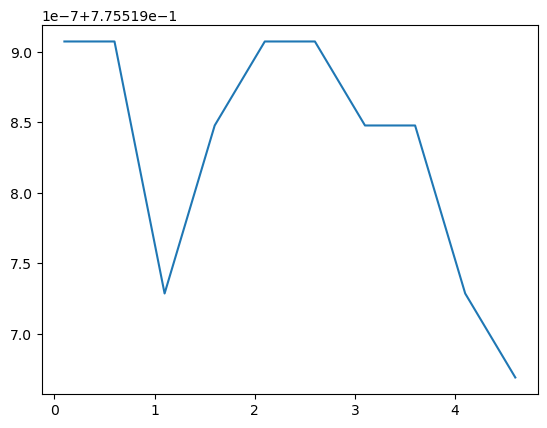

In [37]:
MSE_list=[]
for i in np.arange(0.1, 1, 0.1):
    print(i)
    MSE_list.append(test(test_loader, noise=True, std=i))
x=[i for i in np.arange(0.1, 1, 0.1)]
# dice_list=[i.cpu().item() for i in dice_list]
print(MSE_list)
plt.plot(x,MSE_list)

In [38]:
from IPython.display import FileLink
FileLink('Post_modell_49')

[0.7755199074745178, 0.7755199074745178, 0.7755197286605835, 0.775519847869873, 0.7755199074745178, 0.7755199074745178, 0.775519847869873, 0.775519847869873, 0.7755197286605835, 0.7755196690559387]


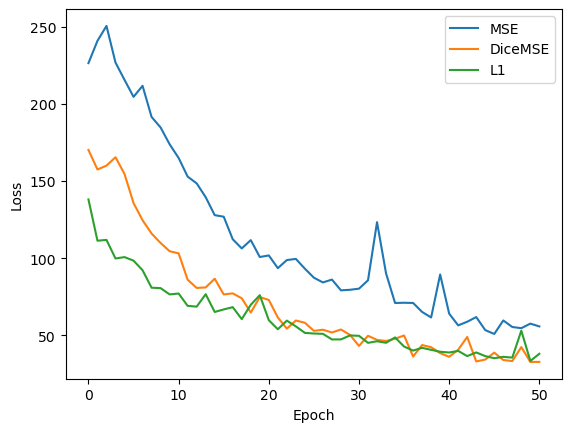

In [18]:
MSE=[226.47610360925847, 240.93070559068158, 250.59123008901423, 226.83232485164297, 215.61711779507723, 204.60724891315806, 211.7590290633115, 191.58081544529307, 184.7554523077878, 173.88500261306763, 164.98631377653643, 152.8959639939395, 148.52019502899864, 139.56805981289256, 127.90968253395774, 126.90133532610807, 112.29386691613631, 106.34097437425093, 111.7238675030795, 100.7696851383556, 101.79845385117964, 93.55239235271107, 98.79305605454879, 99.55069654638118, 93.1929122317921, 87.35605066472834, 84.29544951698996, 86.1457627469843, 79.16924476623535, 79.5269474549727, 80.25136635520242, 85.68040310252796, 123.36270050569014, 90.17684351314197, 70.9637566913258, 71.11943212422457, 70.97979122942144, 65.15094245563854, 61.59179247509349, 89.45418496565385, 64.04824124683033, 56.461132916537196, 58.809719974344425, 61.840787237340756, 53.388898611068726, 50.89376872236078, 59.636105103926226, 55.40108416297219, 54.63809019869024, 57.58890117298473, 55.77768408168446]
MSEDice=[170.19679047844627, 157.50520198995417, 160.01008092273366, 165.4695059602911, 154.59494985233653, 135.74409021030772, 124.63914481076327, 115.99774837493896, 109.86114736036821, 104.52353681217541, 103.14547742496838, 86.03870656273581, 80.72654780474576, 81.05504525791515, 86.69730056415905, 76.50474825772372, 77.19856478951193, 74.01348499818282, 64.7467022375627, 74.7782715884122, 72.92482675205578, 61.586473898454145, 54.32434571873058, 59.60411175814542, 58.15418568524447, 52.90605675090443, 53.613708366047256, 51.85269511829723, 53.780664530667394, 50.29020805792375, 43.12595142017711, 49.71346395665949, 47.02203884991732, 46.31591658158736, 47.803025375713, 49.89085643941706, 36.27099240909923, 43.70225494558161, 42.293050202456385, 38.44810420816595, 36.08055119080977, 40.66057578000155, 48.944157817146994, 33.07533799518239, 34.29698462919755, 38.76908974214034, 34.006575866179034, 33.29216631976041, 42.3840788711201, 32.758888959884644, 32.778817501935094]
L1=[138.11220997030085, 111.33688605915417, 111.87246413664384, 99.81675655191594, 100.70781575549732, 98.41065363450484, 92.19522640921853, 80.86638151515614, 80.6042108969255, 76.52498826113614, 77.09320777112788, 69.09959929639643, 68.6019683751193, 76.65148297223178, 65.14350340583108, 66.78411065448414, 68.27109893885526, 60.509954170747235, 69.79457907243209, 76.03229102221403, 59.816778594797306, 53.92223900014704, 59.53304108706388, 55.79119297591123, 51.592550256035544, 51.17032352360812, 50.96933249993758, 47.33250158483332, 47.35469317436218, 49.91871127215299, 49.69788798418912, 45.12669122219086, 46.16440906307914, 45.15918943015012, 48.64929392121055, 42.71265557679263, 40.11628211628307, 41.904081214558, 40.589863657951355, 39.349888400598005, 38.87021407214078, 39.906524029645055, 36.53209298307245, 38.9067376093431, 36.52074187452143, 35.161965879527, 36.06101738322865, 35.563545324585654, 53.01489345593886, 33.41508668119257, 38.03203525326469]
# labels=["dropout% [0.5, 0.5, 0.3, 0.1]","dropout% [0.5, 0.4, 0.3, 0.2]","dropout% [0.1, 0.2, 0.3, 0.4]","dropout% [0.3, 0.3, 0.3, 0.3]","dropout% [0.6, 0.6, 0.6, 0.6]"]
# for i in range(len(list)):
#     axis=plt.subplot(2,3,i+1)
# plt.title(labels[i])
plt.ticklabel_format(axis='x',useOffset=False)
plt.plot(range(0,51,1),MSE, label='MSE')
plt.plot(range(0,51,1),MSEDice, label='DiceMSE')
# plt.plot(range(0,51,1),L1, label='L1')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
# plt,show()

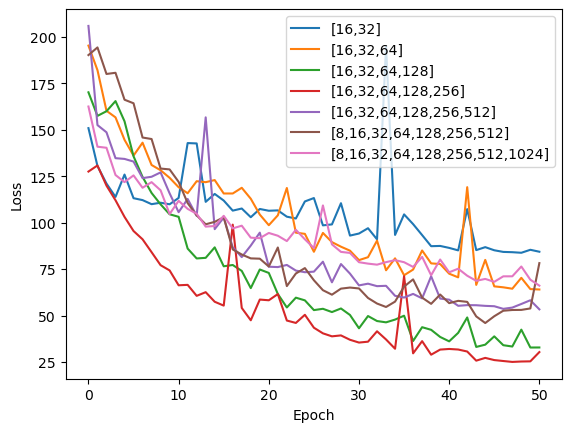

In [19]:
import matplotlib.pyplot as plt
loss=[[150.9095799706199, 130.52166989716616, 121.06799643689936, 113.85896708748557, 125.90551900863647, 113.17492133920842, 112.15124251625754, 109.95768746462736, 110.7365682775324, 109.8949125029824, 113.32034592194991, 142.8618088202043, 142.66967218572444, 111.21236237612638, 115.4762564572421, 111.90799903869629, 106.48468312350187, 107.61617469787598, 102.93589427254416, 107.36994171142578, 106.41556323658337, 106.61315302415328, 103.2202991138805, 102.2424450787631, 111.42953270131892, 113.25741932608865, 98.54704774509777, 99.06328574093905, 110.4770092530684, 93.03800556876443, 94.14929329265247, 97.00929034839977, 91.01806588606401, 194.94572882218793, 93.39274241707541, 104.45128653266214, 99.21739716963334, 93.30842083150691, 87.33094202388416, 87.46509803425182, 86.4110695665533, 85.07218885421753, 107.30519342422485, 85.22468887675892, 86.81114734302868, 85.13179154829545, 84.2477855682373, 84.09613340551203, 83.78441533175382, 85.39193218404597, 84.34373638846658],
[195.35485365174034, 182.1437594240362, 160.2511056986722, 156.7086746042425, 144.62243682687932, 136.1253916350278, 143.08056116104126, 131.06018322164363, 128.2285092527216, 124.15363103693181, 119.08994787389582, 115.84120603041215, 122.3274805762551, 121.80284292047673, 122.94527036493474, 115.71506734327836, 115.7084456357089, 118.7793358889493, 112.88486211950129, 104.35395405509256, 98.63852024078369, 103.95220409740101, 118.67478309978138, 94.61075028506193, 93.96754611622204, 84.32450186122547, 94.47181168469515, 89.5136590870944, 87.05777155269276, 84.92327746477994, 79.82751959020442, 81.40032525496049, 90.31917190551758, 74.36353865536776, 80.7824708331715, 71.67483763261275, 74.73838385668668, 85.01663494110107, 78.0742319280451, 77.71858002922751, 72.51839776472612, 70.54571039026433, 119.1158935806968, 66.48331884904341, 79.94622191515836, 65.69637528332797, 65.1824124509638, 64.42839301716198, 70.2928819656372, 64.23153201016513, 64.00640535354614],
[170.19679047844627, 157.50520198995417, 160.01008092273366, 165.4695059602911, 154.59494985233653, 135.74409021030772, 124.63914481076327, 115.99774837493896, 109.86114736036821, 104.52353681217541, 103.14547742496838, 86.03870656273581, 80.72654780474576, 81.05504525791515, 86.69730056415905, 76.50474825772372, 77.19856478951193, 74.01348499818282, 64.7467022375627, 74.7782715884122, 72.92482675205578, 61.586473898454145, 54.32434571873058, 59.60411175814542, 58.15418568524447, 52.90605675090443, 53.613708366047256, 51.85269511829723, 53.780664530667394, 50.29020805792375, 43.12595142017711, 49.71346395665949, 47.02203884991732, 46.31591658158736, 47.803025375713, 49.89085643941706, 36.27099240909923, 43.70225494558161, 42.293050202456385, 38.44810420816595, 36.08055119080977, 40.66057578000155, 48.944157817146994, 33.07533799518239, 34.29698462919755, 38.76908974214034, 34.006575866179034, 33.29216631976041, 42.3840788711201, 32.758888959884644, 32.778817501935094],
[127.52271582863547, 130.80732690204275, 119.93952835689892, 112.07403042099692, 103.10296583175659, 95.5033374266191, 91.04452592676336, 84.1145792874423, 77.09361228075895, 74.28217085925016, 66.27477208050814, 66.50261462818493, 60.585635618730024, 62.56485366821289, 57.40444061972878, 55.321916276758365, 98.93182563781738, 54.07703000848944, 47.427445281635634, 58.58341477134011, 58.19734391299161, 61.543730692429975, 47.28539605574174, 45.995628963817246, 50.373294136740945, 43.42207462137396, 40.394410220059484, 38.778540567918256, 39.279537894509055, 36.927944053303115, 35.425034913149744, 35.89900281212547, 41.49411305514249, 37.08818554878235, 32.09796621582725, 71.16681276668201, 29.62372810190374, 36.18458483435891, 28.8883563821966, 31.64670892195268, 31.980247952721335, 31.678962664170697, 30.602124842730436, 25.681061159480702, 27.17384247346358, 25.995693228461526, 25.48905827782371, 25.000214533372358, 25.225518703460693, 25.31148875843395, 30.297535809603605],
[205.95642789512389, 152.55174584822223, 148.67135420712557, 134.73012447357178, 134.3338354284113, 132.90184142372826, 123.98891388286243, 124.72123588215221, 127.07028943842107, 115.7814583344893, 105.6464488289573, 112.76271455938166, 103.6800889968872, 156.71505416523325, 96.49797851389104, 102.73408490961248, 86.76272470300847, 81.45916990800337, 87.66135987368497, 94.6257720860568, 76.27334707433528, 76.07930759950118, 77.23234033584595, 74.18854540044612, 73.31419506939974, 73.6089825630188, 78.9791688485579, 67.87717775865035, 77.70509563792835, 72.5558798529885, 66.21292768825184, 67.14135148308493, 65.8053069114685, 65.99270088022405, 60.603306250138715, 59.67152214050293, 61.632083199240945, 59.23216577009721, 71.11819891496138, 59.11335893110795, 58.52648984302174, 55.223085620186545, 55.588819633830674, 55.53765541856939, 55.19116869839755, 54.997146433049984, 53.58233965526927, 54.26446580886841, 56.20529538934881, 58.2093016017567, 53.314243750138715],
[190.25139979882672, 194.37081904844806, 180.0792247056961, 180.71738841316918, 166.21264761144465, 164.29563262245873, 145.84955451705238, 145.04531435533002, 129.1387051235546, 128.67954206466675, 121.9664888381958, 110.55209771069613, 103.92974862185392, 99.11402546275745, 100.44004769758745, 102.89809469743209, 85.58056983080778, 82.84406332536177, 80.76132826371627, 80.59788764606823, 76.38855817101218, 86.62688541412354, 65.84114941683683, 72.6124985001304, 75.53336282209916, 68.98623466491699, 63.629346804185346, 61.20992305062034, 64.46562723679976, 65.05046484687112, 64.56862315264615, 59.43978235938332, 56.445768399672076, 54.5820986140858, 57.48299733075228, 65.56716970963912, 69.45399032939564, 59.63339818607677, 56.28173745762218, 61.29050579938021, 56.654596372084185, 57.891941417347304, 57.343558918346055, 49.5168765891682, 45.94640003551137, 49.60391426086426, 52.569325577129014, 52.96700867739591, 53.019615780223496, 53.805025057359174, 78.21682531183416],
[162.55387661673805, 140.90931875055486, 140.33205101706764, 125.66356112740256, 121.846003705805, 125.45204032551159, 118.79566253315319, 121.82096932151101, 117.43059206008911, 104.65900377793746103, 111.75873504985462, 107.43669206445867, 104.79326100782914, 97.88015452298251, 98.18483998558737, 103.69272128018466, 96.91358436237682, 98.36669570749456, 91.91170276295055, 91.63700311834162, 94.45527137409557, 92.96362985264172, 90.08495300466365, 96.14556845751676, 91.03879156979647, 86.30140456286344, 109.28396342017435, 88.31745836951517, 84.26526568152688, 83.70122918215665, 78.69938481937756, 77.94229420748624, 77.38179662010886, 78.73528809980913, 79.8115643154491, 78.70507738806985, 76.16366455771707, 81.5739297433333, 71.6798964847218, 80.14919909563932, 73.26794966784391, 75.20749781348489, 71.4265489578247, 68.67984962463379, 69.69740442796187, 68.145685932853, 71.09223868630149, 71.10809456218372, 76.39121142300692, 69.27949064428157, 66.08017843419856]]

labels=["[16,32]","[16,32,64]","[16,32,64,128]","[16,32,64,128,256]","[16,32,64,128,256,512]","[8,16,32,64,128,256,512]","[8,16,32,64,128,256,512,1024]"]
plt.ticklabel_format(axis='x',useOffset=False)
for i,j in zip(loss,labels):
    plt.plot(range(0,51,1),i,label=j)
# plt.plot(range(0,51,1),MSE, label='With inception module')
# plt.plot(range(0,51,1),MSEDice, label='Without inception module')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
# print(len(loss[6]))

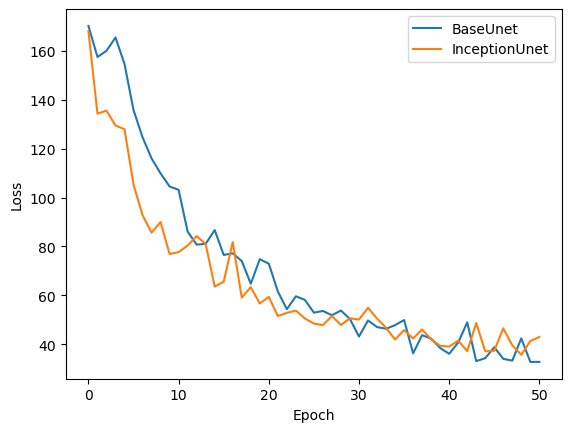

In [43]:
BaseUnet=[170.19679047844627, 157.50520198995417, 160.01008092273366, 165.4695059602911, 154.59494985233653, 135.74409021030772, 124.63914481076327, 115.99774837493896, 109.86114736036821, 104.52353681217541, 103.14547742496838, 86.03870656273581, 80.72654780474576, 81.05504525791515, 86.69730056415905, 76.50474825772372, 77.19856478951193, 74.01348499818282, 64.7467022375627, 74.7782715884122, 72.92482675205578, 61.586473898454145, 54.32434571873058, 59.60411175814542, 58.15418568524447, 52.90605675090443, 53.613708366047256, 51.85269511829723, 53.780664530667394, 50.29020805792375, 43.12595142017711, 49.71346395665949, 47.02203884991732, 46.31591658158736, 47.803025375713, 49.89085643941706, 36.27099240909923, 43.70225494558161, 42.293050202456385, 38.44810420816595, 36.08055119080977, 40.66057578000155, 48.944157817146994, 33.07533799518239, 34.29698462919755, 38.76908974214034, 34.006575866179034, 33.29216631976041, 42.3840788711201, 32.758888959884644, 32.778817501935094]
InceptionUnet=[168.11458917097613, 134.32502269744873, 135.527644070712, 129.46062729575416, 127.94211691076106, 105.3003909371116, 92.75085210800171, 85.63748398694125, 89.98464939811014, 76.8955213806846, 77.67179757898504, 80.3549691547047, 84.23088574409485, 80.9485821723938, 63.562691341746934, 65.56685681776567, 81.74629909341985, 59.0978038744493, 63.34941092404452, 56.651912299069494, 59.36067615855824, 51.549435962330215, 52.81725096702576, 53.76440490375865, 50.5157300342213, 48.43508700890975, 47.80098524960604, 51.54702481356534, 47.85599567673423, 50.583733797073364, 50.09233817187223, 54.89218235015869, 50.49514356526461, 46.74251786145297, 41.89391396262429, 45.76941795782609, 42.343705675818704, 46.01443524794145, 41.98639687624845, 39.319129911336034, 39.02795594388788, 41.43910722299056, 37.16633881222118, 48.65714963999662, 37.0681670145555, 37.31022418629039, 46.491972338069566, 39.50648591735146, 35.6595963564786, 41.31896079670299, 42.93777684731917]
# L1=[138.11220997030085, 111.33688605915417, 111.87246413664384, 99.81675655191594, 100.70781575549732, 98.41065363450484, 92.19522640921853, 80.86638151515614, 80.6042108969255, 76.52498826113614, 77.09320777112788, 69.09959929639643, 68.6019683751193, 76.65148297223178, 65.14350340583108, 66.78411065448414, 68.27109893885526, 60.509954170747235, 69.79457907243209, 76.03229102221403, 59.816778594797306, 53.92223900014704, 59.53304108706388, 55.79119297591123, 51.592550256035544, 51.17032352360812, 50.96933249993758, 47.33250158483332, 47.35469317436218, 49.91871127215299, 49.69788798418912, 45.12669122219086, 46.16440906307914, 45.15918943015012, 48.64929392121055, 42.71265557679263, 40.11628211628307, 41.904081214558, 40.589863657951355, 39.349888400598005, 38.87021407214078, 39.906524029645055, 36.53209298307245, 38.9067376093431, 36.52074187452143, 35.161965879527, 36.06101738322865, 35.563545324585654, 53.01489345593886, 33.41508668119257, 38.03203525326469]
# labels=["dropout% [0.5, 0.5, 0.3, 0.1]","dropout% [0.5, 0.4, 0.3, 0.2]","dropout% [0.1, 0.2, 0.3, 0.4]","dropout% [0.3, 0.3, 0.3, 0.3]","dropout% [0.6, 0.6, 0.6, 0.6]"]
# for i in range(len(list)):
#     axis=plt.subplot(2,3,i+1)
# plt.title(labels[i])
plt.ticklabel_format(axis='x',useOffset=False)
plt.plot(range(0,51,1),BaseUnet, label='BaseUnet')
plt.plot(range(0,51,1),InceptionUnet, label='InceptionUnet')
# plt.plot(range(0,51,1),L1, label='L1')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
# plt,show()

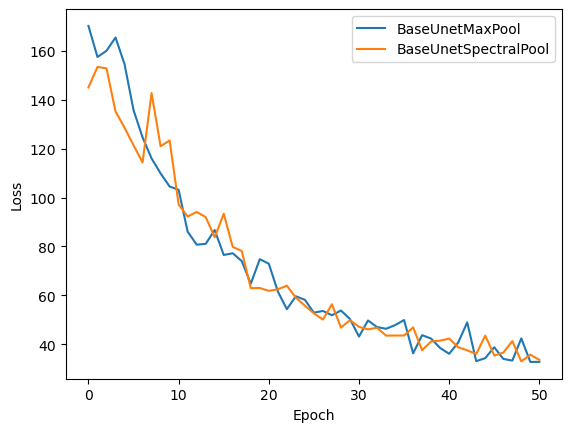

In [74]:

BaseUnetMaxPool=[170.19679047844627, 157.50520198995417, 160.01008092273366, 165.4695059602911, 154.59494985233653, 135.74409021030772, 124.63914481076327, 115.99774837493896, 109.86114736036821, 104.52353681217541, 103.14547742496838, 86.03870656273581, 80.72654780474576, 81.05504525791515, 86.69730056415905, 76.50474825772372, 77.19856478951193, 74.01348499818282, 64.7467022375627, 74.7782715884122, 72.92482675205578, 61.586473898454145, 54.32434571873058, 59.60411175814542, 58.15418568524447, 52.90605675090443, 53.613708366047256, 51.85269511829723, 53.780664530667394, 50.29020805792375, 43.12595142017711, 49.71346395665949, 47.02203884991732, 46.31591658158736, 47.803025375713, 49.89085643941706, 36.27099240909923, 43.70225494558161, 42.293050202456385, 38.44810420816595, 36.08055119080977, 40.66057578000155, 48.944157817146994, 33.07533799518239, 34.29698462919755, 38.76908974214034, 34.006575866179034, 33.29216631976041, 42.3840788711201, 32.758888959884644, 32.778817501935094]
BaseUnetSpectralPool=[145.02715236490423, 153.416447205977, 152.84636410799894, 135.22285001928157, 128.57600220766935, 121.39597077803178, 114.34241277521306, 142.74119732596657, 120.99419602480802, 123.33256097273393, 97.15418702905828, 92.2361267263239, 94.09494651447643, 92.03429881009188, 83.74480837041682, 93.38314329494129, 79.79762840270996, 78.1292346607555, 62.92722459272905, 62.98946892131459, 61.82384490966797, 62.466754306446425, 63.93642828681252, 59.03446396914396, 55.76135032827204, 52.60280873558738, 50.091234012083575, 56.33891903270375, 46.818120739676736, 49.84362209926952, 47.11190537972884, 46.0758900642395, 46.75192431970076, 43.520837025208905, 43.55458749424327, 43.56115529753945, 46.89176496592435, 37.55021717331626, 41.129465926777236, 41.449497959830545, 42.3234048539942, 38.758225744420834, 37.49647517637773, 36.013751615177505, 43.50376835736361, 35.391703670675106, 36.54576362263072, 41.272441387176514, 32.994236274199054, 35.70490316911177, 33.58083321831443]
# L1=[138.11220997030085, 111.33688605915417, 111.87246413664384, 99.81675655191594, 100.70781575549732, 98.41065363450484, 92.19522640921853, 80.86638151515614, 80.6042108969255, 76.52498826113614, 77.09320777112788, 69.09959929639643, 68.6019683751193, 76.65148297223178, 65.14350340583108, 66.78411065448414, 68.27109893885526, 60.509954170747235, 69.79457907243209, 76.03229102221403, 59.816778594797306, 53.92223900014704, 59.53304108706388, 55.79119297591123, 51.592550256035544, 51.17032352360812, 50.96933249993758, 47.33250158483332, 47.35469317436218, 49.91871127215299, 49.69788798418912, 45.12669122219086, 46.16440906307914, 45.15918943015012, 48.64929392121055, 42.71265557679263, 40.11628211628307, 41.904081214558, 40.589863657951355, 39.349888400598005, 38.87021407214078, 39.906524029645055, 36.53209298307245, 38.9067376093431, 36.52074187452143, 35.161965879527, 36.06101738322865, 35.563545324585654, 53.01489345593886, 33.41508668119257, 38.03203525326469]
# labels=["dropout% [0.5, 0.5, 0.3, 0.1]","dropout% [0.5, 0.4, 0.3, 0.2]","dropout% [0.1, 0.2, 0.3, 0.4]","dropout% [0.3, 0.3, 0.3, 0.3]","dropout% [0.6, 0.6, 0.6, 0.6]"]
# for i in range(len(list)):
#     axis=plt.subplot(2,3,i+1)
# plt.title(labels[i])
plt.ticklabel_format(axis='x',useOffset=False)
plt.plot(range(0,51,1),BaseUnetMaxPool, label='BaseUnetMaxPool')
plt.plot(range(0,51,1),BaseUnetSpectralPool, label='BaseUnetSpectralPool')
# plt.plot(range(0,51,1),L1, label='L1')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
# plt,show()

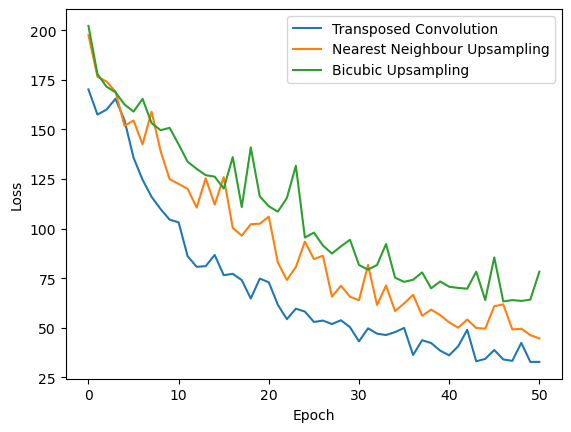

In [43]:
# [197.56285285949707, 176.55781841278076, 174.19856418262827, 169.08106396415016, 151.82859308069402, 154.5287628173828, 142.4950784336437, 8558.936461622065, 139.08775147524747, 124.93639139695601, 122.54980195652355, 120.04603997143832, 110.60770685022527, 125.36227156899191, 112.10939199274236, 126.00437198985706, 100.35616263476285, 96.4436036456715, 102.2069922360507, 102.4469505223361, 106.0233902497725, 82.92732087048617, 74.10420985655351, 80.62295194105668, 93.44707415320657, 84.61348542300138, 86.32020711898804, 65.65446888316761, 71.18622372367166, 65.66206736998124, 63.87161142175848, 81.6787543296814, 61.46461976658214, 71.26877815073186, 58.3899893543937, 62.254349101673476, 66.61832818118009, 56.03048229217529, 59.13788808475841, 56.404414263638586, 52.72419292276556, 50.01885533332825, 54.1484509381381, 49.871751221743494, 49.5513014793396, 60.833805257623844, 61.7857733856548, 49.14547742496837, 49.51071108471263, 46.28453449769454, 44.62002305551009]
TransposeConv=[170.19679047844627, 157.50520198995417, 160.01008092273366, 165.4695059602911, 154.59494985233653, 135.74409021030772, 124.63914481076327, 115.99774837493896, 109.86114736036821, 104.52353681217541, 103.14547742496838, 86.03870656273581, 80.72654780474576, 81.05504525791515, 86.69730056415905, 76.50474825772372, 77.19856478951193, 74.01348499818282, 64.7467022375627, 74.7782715884122, 72.92482675205578, 61.586473898454145, 54.32434571873058, 59.60411175814542, 58.15418568524447, 52.90605675090443, 53.613708366047256, 51.85269511829723, 53.780664530667394, 50.29020805792375, 43.12595142017711, 49.71346395665949, 47.02203884991732, 46.31591658158736, 47.803025375713, 49.89085643941706, 36.27099240909923, 43.70225494558161, 42.293050202456385, 38.44810420816595, 36.08055119080977, 40.66057578000155, 48.944157817146994, 33.07533799518239, 34.29698462919755, 38.76908974214034, 34.006575866179034, 33.29216631976041, 42.3840788711201, 32.758888959884644, 32.778817501935094]
NearestNeighbourUpsampling=[197.56285285949707, 176.55781841278076, 174.19856418262827, 169.08106396415016, 151.82859308069402, 154.5287628173828, 142.4950784336437, 158.936461622065, 139.08775147524747, 124.93639139695601, 122.54980195652355, 120.04603997143832, 110.60770685022527, 125.36227156899191, 112.10939199274236, 126.00437198985706, 100.35616263476285, 96.4436036456715, 102.2069922360507, 102.4469505223361, 106.0233902497725, 82.92732087048617, 74.10420985655351, 80.62295194105668, 93.44707415320657, 84.61348542300138, 86.32020711898804, 65.65446888316761, 71.18622372367166, 65.66206736998124, 63.87161142175848, 81.6787543296814, 61.46461976658214, 71.26877815073186, 58.3899893543937, 62.254349101673476, 66.61832818118009, 56.03048229217529, 59.13788808475841, 56.404414263638586, 52.72419292276556, 50.01885533332825, 54.1484509381381, 49.871751221743494, 49.5513014793396, 60.833805257623844, 61.7857733856548, 49.14547742496837, 49.51071108471263, 46.28453449769454, 44.62002305551009]
BicubicUpsampling=[202.21808841011742, 177.91849119013006, 171.58594443581322, 168.7410321669145, 162.58952869068492, 159.0180925022472, 165.43342503634366, 153.21870248967952, 149.60940118269488, 150.821401162581, 142.47210017117587, 133.69177402149546, 130.11647766286677, 126.9492219578136, 126.20519716089422, 120.1971454186873, 136.045485756614, 110.89095978303389, 140.92356941916725, 116.2234244780107, 111.2598876953125, 108.53263898329301, 115.39253490621394, 131.702135649595, 95.4876464063471, 97.98044859279285, 91.45602308620106, 87.41603899002075, 91.06499268791892, 94.3597763668407, 81.68938966230913, 79.29267618872903, 81.68187605250965, 92.22021913528442, 75.2574027668346, 73.13424288142811, 74.19056849046187, 77.89865762537175, 69.86993031068282, 73.31872077421708, 70.69056205316024, 70.07878385890614, 69.68496060371399, 78.29696063561873, 63.94600300355391, 85.47719084132801, 63.270624139092185, 63.955520911650225, 63.51618233594027, 64.16791512749411, 78.27607666362415]
# L1=[138.11220997030085, 111.33688605915417, 111.87246413664384, 99.81675655191594, 100.70781575549732, 98.41065363450484, 92.19522640921853, 80.86638151515614, 80.6042108969255, 76.52498826113614, 77.09320777112788, 69.09959929639643, 68.6019683751193, 76.65148297223178, 65.14350340583108, 66.78411065448414, 68.27109893885526, 60.509954170747235, 69.79457907243209, 76.03229102221403, 59.816778594797306, 53.92223900014704, 59.53304108706388, 55.79119297591123, 51.592550256035544, 51.17032352360812, 50.96933249993758, 47.33250158483332, 47.35469317436218, 49.91871127215299, 49.69788798418912, 45.12669122219086, 46.16440906307914, 45.15918943015012, 48.64929392121055, 42.71265557679263, 40.11628211628307, 41.904081214558, 40.589863657951355, 39.349888400598005, 38.87021407214078, 39.906524029645055, 36.53209298307245, 38.9067376093431, 36.52074187452143, 35.161965879527, 36.06101738322865, 35.563545324585654, 53.01489345593886, 33.41508668119257, 38.03203525326469]
# labels=["dropout% [0.5, 0.5, 0.3, 0.1]","dropout% [0.5, 0.4, 0.3, 0.2]","dropout% [0.1, 0.2, 0.3, 0.4]","dropout% [0.3, 0.3, 0.3, 0.3]","dropout% [0.6, 0.6, 0.6, 0.6]"]
# for i in range(len(list)):
#     axis=plt.subplot(2,3,i+1)
# plt.title(labels[i])
plt.ticklabel_format(axis='x',useOffset=False)
plt.plot(range(0,51,1),TransposeConv, label='Transposed Convolution')
plt.plot(range(0,51,1),NearestNeighbourUpsampling, label='Nearest Neighbour Upsampling')
plt.plot(range(0,51,1),BicubicUpsampling, label='Bicubic Upsampling')
# plt.plot(range(0,51,1),L1, label='L1')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
# plt,show()